In [147]:
import os
import glob
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from cycler import cycler

import plotly

%matplotlib inline

In [98]:
# inputs
input_folder = '../csse_covid_19_data/csse_covid_19_daily_reports'
fmt = '.csv'

In [99]:
# grab and merge input csvs
data_files = glob.glob(os.path.join(input_folder, '*{}'.format(fmt)))

df = pd.DataFrame()
for i, filename in enumerate(data_files):
    new_data = pd.read_csv(filename)
    df = df.append(new_data)

/Users/yameng/workspace/python_envs/py3_default/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [172]:
# clean up data
def cleanup_date(x):
#     print(x)
    y, m, d = 0, 0, 0
    if 'T' in x:
        y, m, d = x.split('T')[0].split('-')
    elif ' ' in x:
        m, d, y = x.split(' ')[0].split('/')
    y = '20' + y if len(y) < 4 else y
    m = '0' + m if len(m) < 2 else m
    d = '0' + d if len(d) < 2 else d
    return '-'.join([y, m, d])

df['update_date'] = df['Last Update'].apply(lambda x: cleanup_date(x))
df = df.sort_values(by=['update_date'])

# unify country names
def unify_country_names(x, candidates, target):
    if x in candidates:
        return target
    else:
        return x

# merge "China" and "Mainland China", "UK" and "United Kindom"
df['Country/Region'] = df['Country/Region'].apply(lambda x: unify_country_names(x, candidates=['Mainland China', 'China'], target='China'))
df['Country/Region'] = df['Country/Region'].apply(lambda x: unify_country_names(x, candidates=['UK', 'United Kingdom'], target='United Kingdom'))



In [171]:
# overview
num_regions = df['Country/Region'].unique().shape[0]
num_days = df['update_date'].unique().shape[0]

latest_date = df['update_date'].max()

num_confirmed_agg = df[df['update_date'] == latest_date]['Confirmed'].sum()
num_death = df[df['update_date'] == latest_date]['Deaths'].sum()
num_recovered = df[df['update_date'] == latest_date]['Recovered'].sum()

case_fatality_rate = num_death / num_confirmed_agg

latest_date = df['update_date'].max()

print("Overview: till {}, in {} days, Covid-19 has spread into {} Countries/ Regions".format(latest_date, num_days, num_regions))
print("Total confirmed cases: {}, recovered: {}, deaths: {}".format(int(num_confirmed_agg), int(num_recovered), int(num_death)))
print("Case Fatality Rate: {:04.2f}%".format(case_fatality_rate * 100))

Overview: till 2020-03-16, in 55 days, Covid-19 has spread into 184 Countries/ Regions
Total confirmed cases: 171463, recovered: 70803, deaths: 7046
Case Fatality Rate: 4.11%


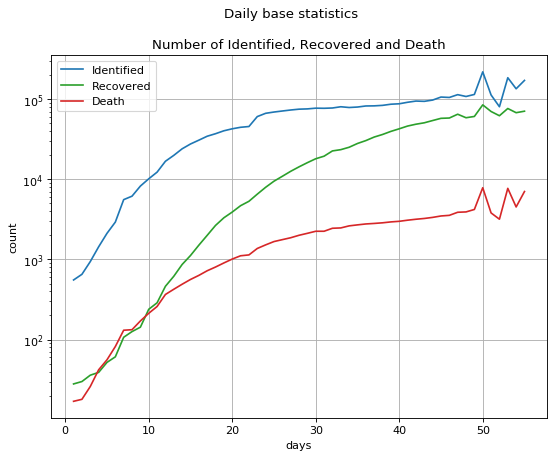

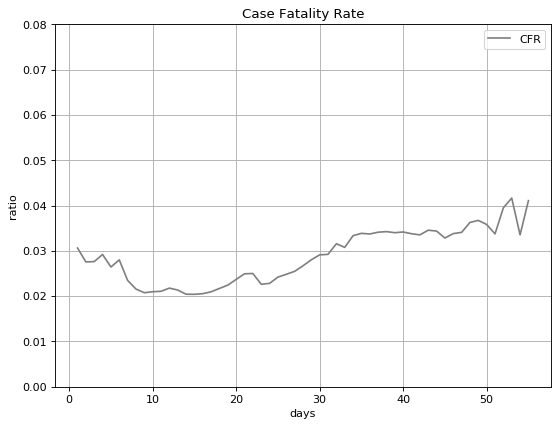

In [159]:
# time based aggregation
df_time = df.groupby(by='update_date')

date = []
days = []
num_identified = [0]
num_recovered = [0]
num_deaths = [0]
cfrs = []
for i, (t, frame) in enumerate(df_time):
    date.append(t)
    days.append(i + 1)
    num_identified.append(frame['Confirmed'].sum())
    num_recovered.append(frame['Recovered'].sum())
    num_deaths.append(frame['Deaths'].sum())
    cfrs.append(num_deaths[-1] / num_identified[-1])

num_identified = num_identified[1: ]
num_recovered = num_recovered[1: ]
num_deaths = num_deaths[1: ]

fig, axs = plt.subplots(1, sharex=True, figsize=(8, 6), dpi= 80, facecolor='w', edgecolor='k')
fig.suptitle('Daily base statistics')

axs.plot(days, num_identified)
axs.set_title('Number of Identified, Recovered and Death')
axs.set(xlabel='days', ylabel='count')
axs.set_yscale('log')

axs.plot(days, num_recovered, 'tab:green')
axs.set(xlabel='days', ylabel='count')
axs.set_yscale('log')

axs.plot(days, num_deaths, 'tab:red')
axs.set(xlabel='days', ylabel='count')
axs.set_yscale('log')
axs.grid()

axs.legend(['Identified', 'Recovered', 'Death'])

for axi in fig.get_axes():
    axi.label_outer()

fig, ax = plt.subplots(1, figsize=(8, 6), dpi= 80, facecolor='w', edgecolor='k')
ax.plot(days, cfrs, 'tab:gray')
ax.set_title('Case Fatality Rate')
ax.set(xlabel='days', ylabel='ratio')
ax.set_ylim(0, 0.08)
ax.legend(['CFR'])
ax.grid()


Text(0.5, 0.98, 'Case Fatality Rate Country/Region-wise in days')

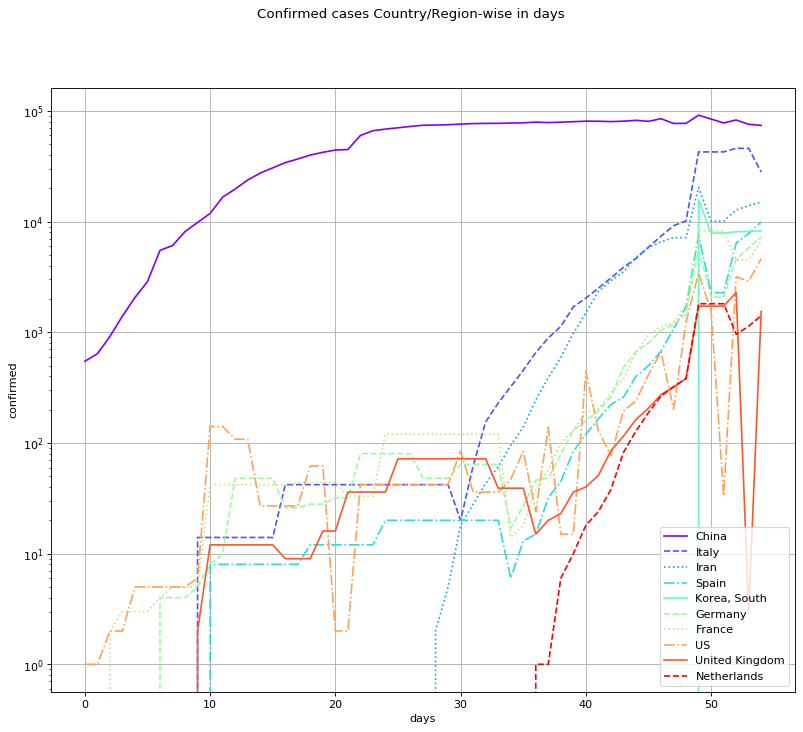

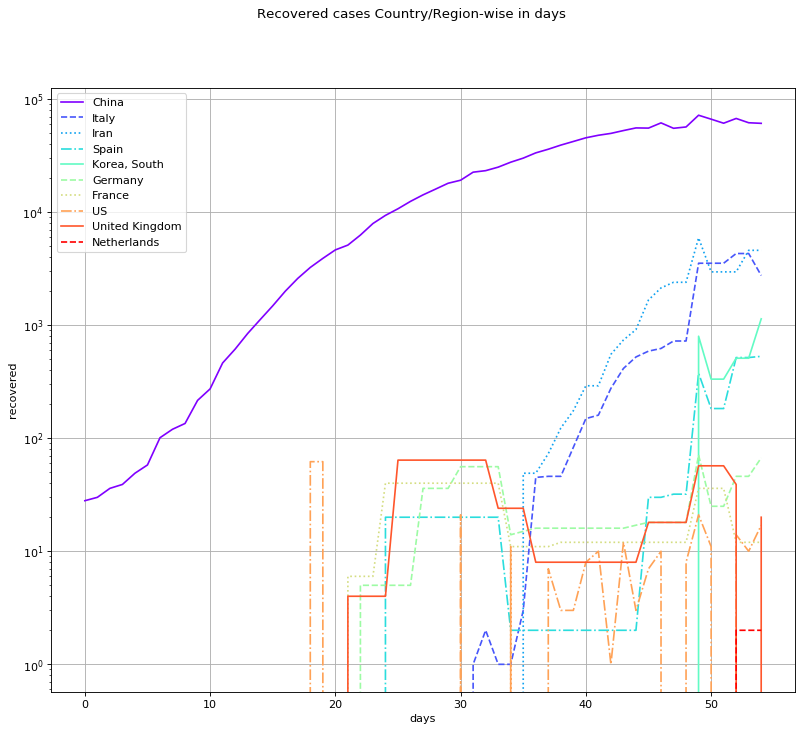

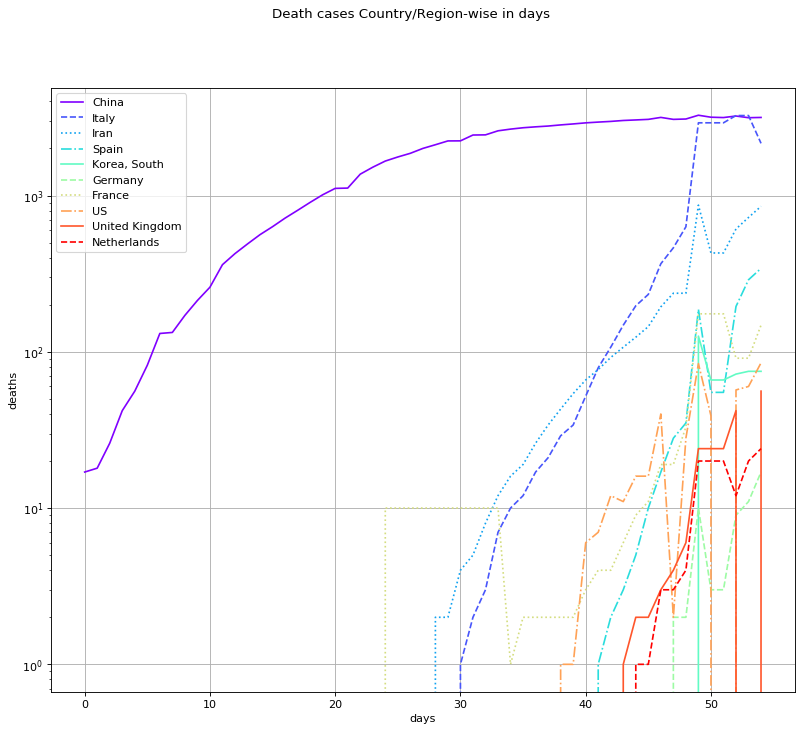

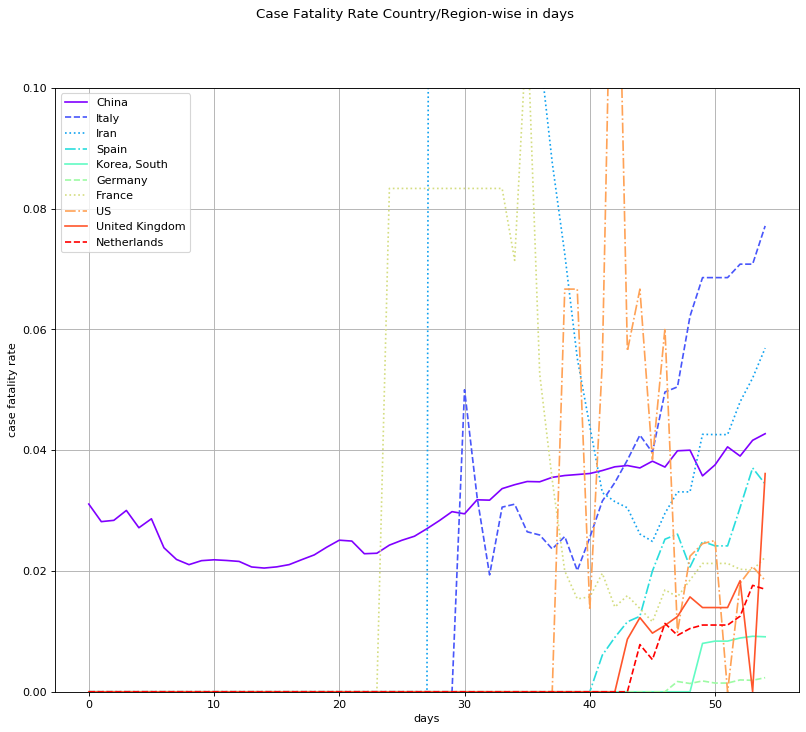

In [170]:
# nation wise, try to select top N countries
N = 10
latest_date = df['update_date'].max()
df_last_day = df[df['update_date'] == latest_date]

df_statewise = df_last_day.groupby(by='Country/Region')

count_confirmed = {}
for country, frame in df_statewise:
    total_confirmed = frame['Confirmed'].sum()
    count_confirmed[country] = total_confirmed

confirmed_sorted = {k: v for k, v in sorted(count_confirmed.items(), key=lambda item: item[1], reverse=True)}
state_selected = list(confirmed_sorted.keys())[: N]

# gather plotting data in country wise
state_daywise = {}
dates = list(df['update_date'].unique())
for i, date in enumerate(dates):
    df_date = df[df['update_date'] == date]
    for j, state in enumerate(state_selected):
        if state not in state_daywise:
            state_daywise[state] = {'Confirmed': [], 
                                    'Recovered': [],
                                    'Deaths': [],
                                    'CFR': []}
        
        df_state = df_date[df_date['Country/Region'] == state]
        if df_state.shape[0] == 0:
            state_daywise[state]['Confirmed'].append(0 if len(state_daywise[state]['Confirmed']) == 0 else state_daywise[state]['Confirmed'][-1])
            state_daywise[state]['Recovered'].append(0 if len(state_daywise[state]['Recovered']) == 0 else state_daywise[state]['Recovered'][-1])
            state_daywise[state]['Deaths'].append(0 if len(state_daywise[state]['Deaths']) == 0 else state_daywise[state]['Deaths'][-1])
            state_daywise[state]['CFR'].append(0 if len(state_daywise[state]['CFR']) == 0 else state_daywise[state]['CFR'][-1])
        else:
            state_daywise[state]['Confirmed'].append(df_state['Confirmed'].sum())
            state_daywise[state]['Recovered'].append(df_state['Recovered'].sum())
            state_daywise[state]['Deaths'].append(df_state['Deaths'].sum())
            state_daywise[state]['CFR'].append(min(1., df_state['Deaths'].sum() / df_state['Confirmed'].sum()))

# plot confirmed cases
color = cm.rainbow(np.linspace(0,1,N))
line_styles = ['-', '--', ':', '-.']
fig, ax = plt.subplots(1, sharex=True, figsize=(12, 10), 
                       dpi= 80, facecolor='w', edgecolor='k')
ax.set_yscale('log')
ax.set_prop_cycle(cycler('color', color))
xs = list(range(df['update_date'].unique().shape[0]))
for i, key in enumerate(state_daywise.keys()):
    ys = state_daywise[key]['Confirmed']
    ax.plot(xs, ys, line_styles[i % len(line_styles)])
ax.legend(state_daywise.keys())
ax.set(xlabel='days', ylabel='confirmed')
ax.grid()
fig.suptitle('Confirmed cases Country/Region-wise in days')

# plot recovered cases
fig, ax = plt.subplots(1, sharex=True, figsize=(12, 10), 
                       dpi= 80, facecolor='w', edgecolor='k')
ax.set_yscale('log')
ax.set_prop_cycle(cycler('color', color))
xs = list(range(df['update_date'].unique().shape[0]))
for i, key in enumerate(state_daywise.keys()):
    ys = state_daywise[key]['Recovered']
    ax.plot(xs, ys, line_styles[i % len(line_styles)])
ax.legend(state_daywise.keys())
ax.set(xlabel='days', ylabel='recovered')
ax.grid()
fig.suptitle('Recovered cases Country/Region-wise in days')

# plot deaths cases
fig, ax = plt.subplots(1, sharex=True, figsize=(12, 10), 
                       dpi= 80, facecolor='w', edgecolor='k')
ax.set_yscale('log')
ax.set_prop_cycle(cycler('color', color))
xs = list(range(df['update_date'].unique().shape[0]))
for i, key in enumerate(state_daywise.keys()):
    ys = state_daywise[key]['Deaths']
    ax.plot(xs, ys, line_styles[i % len(line_styles)])
ax.legend(state_daywise.keys())
ax.set(xlabel='days', ylabel='deaths')
ax.grid()
fig.suptitle('Death cases Country/Region-wise in days')

# plot cfr cases
fig, ax = plt.subplots(1, sharex=True, figsize=(12, 10), 
                       dpi= 80, facecolor='w', edgecolor='k')
ax.set_ylim(0, 0.10)
ax.set_prop_cycle(cycler('color', color))
xs = list(range(df['update_date'].unique().shape[0]))
for i, key in enumerate(state_daywise.keys()):
    ys = state_daywise[key]['CFR']
    ax.plot(xs, ys, line_styles[i % len(line_styles)])
ax.legend(state_daywise.keys())
ax.set(xlabel='days', ylabel='case fatality rate')
ax.grid()
fig.suptitle('Case Fatality Rate Country/Region-wise in days')
    

In [45]:
df.head()

,Confirmed,Country/Region,Deaths,Last Update,Latitude,Longitude,Province/State,Recovered,update_date
3,1.0,Mainland China,NaN,1/22/2020 17:00,NaN,NaN,Fujian,NaN,2020-01-22
24,2.0,Mainland China,NaN,1/22/2020 17:00,NaN,NaN,Shandong,NaN,2020-01-22
8,4.0,Mainland China,NaN,1/22/2020 17:00,NaN,NaN,Hainan,NaN,2020-01-22
23,NaN,Mainland China,NaN,1/22/2020 17:00,NaN,NaN,Shaanxi,NaN,2020-01-22
21,1.0,Mainland China,NaN,1/22/2020 17:00,NaN,NaN,Ningxia,NaN,2020-01-22


In [39]:
df[df['update_date'] == '2020-31-01']

,Confirmed,Country/Region,Deaths,Last Update,Latitude,Longitude,Province/State,Recovered,update_date
56,1.0,Cambodia,NaN,1/31/2020 23:59,NaN,NaN,NaN,NaN,2020-31-01
57,1.0,Sri Lanka,NaN,1/31/2020 23:59,NaN,NaN,NaN,NaN,2020-31-01
58,1.0,Finland,NaN,1/31/2020 23:59,NaN,NaN,NaN,NaN,2020-31-01
55,1.0,Canada,NaN,1/31/2020 23:59,NaN,NaN,British Columbia,NaN,2020-31-01
60,1.0,India,NaN,1/31/2020 23:59,NaN,NaN,NaN,NaN,2020-31-01
...,...,...,...,...,...,...,...,...,...
24,29.0,Mainland China,NaN,1/31/2020 23:59,NaN,NaN,Gansu,NaN,2020-31-01
23,29.0,Mainland China,NaN,1/31/2020 23:59,NaN,NaN,Guizhou,2.0,2020-31-01
22,32.0,Mainland China,NaN,1/31/2020 23:59,NaN,NaN,Tianjin,NaN,2020-31-01
36,13.0,Singapore,NaN,1/31/2020 23:59,NaN,NaN,NaN,NaN,2020-31-01


In [156]:
df['Country/Region'].unique()

array(['China', 'Hong Kong', 'Thailand', 'US', 'Macau', 'Taiwan', 'Japan',
       'South Korea', 'Philippines', 'Malaysia', 'Colombia', 'Brazil',
       'Australia', 'Vietnam', 'Singapore', 'Mexico', 'France', 'Nepal',
       'Canada', 'Cambodia', 'Ivory Coast', 'Sri Lanka', 'Germany',
       'Finland', 'United Arab Emirates', 'India', 'Italy', 'Russia',
       'Sweden', 'UK', 'Spain', 'Belgium', 'Others', 'Egypt', 'Iran',
       'Lebanon', 'Israel', 'Iraq', 'Afghanistan', 'Bahrain', 'Oman',
       'Kuwait', 'Switzerland', 'Algeria', 'Austria', 'Croatia',
       'Pakistan', 'Romania', 'Georgia', 'Greece', 'North Macedonia',
       'Norway', 'San Marino', 'Denmark', 'Estonia', 'Netherlands',
       'Lithuania', 'Nigeria', 'New Zealand', ' Azerbaijan', 'Belarus',
       'North Ireland', 'Iceland', 'Monaco', 'Ireland', 'Luxembourg',
       'Qatar', 'Ecuador', 'Armenia', 'Azerbaijan', 'Czech Republic',
       'Dominican Republic', 'Andorra', 'Indonesia', 'Saudi Arabia',
       'Latvia', 'S

In [155]:
state_daywise['US']['Confirmed']

[1.0,
 1.0,
 2.0,
 2.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 6.0,
 141.0,
 141.0,
 108.0,
 108.0,
 27.0,
 27.0,
 27.0,
 27.0,
 62.0,
 62.0,
 2.0,
 2.0,
 42.0,
 42.0,
 42.0,
 42.0,
 42.0,
 42.0,
 42.0,
 42.0,
 84.0,
 36.0,
 36.0,
 36.0,
 47.0,
 84.0,
 24.0,
 139.0,
 15.0,
 15.0,
 442.0,
 128.0,
 77.0,
 195.0,
 240.0,
 416.0,
 665.0,
 203.0,
 1247.0,
 3425.0,
 1557.0,
 33.0,
 3170.0,
 2895.0,
 4612.0]